In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from nltk import sent_tokenize
import torch
from transformers import(
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
     T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
)


In [ ]:
# !pip install datasets

In [ ]:
# !pip install transformers[torch]

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
dataset = load_dataset("squad")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
traind = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.20)))
validiationd = dataset['validation'].shuffle(seed=42).select(range(int(len(dataset['validation']) * 0.20)))


In [ ]:

def preprocess_function(examples):
    # Adjust these tokens based on the specifics of your chosen model and task
    inputs = ["context: " + doc for doc in examples['context']]
    targets = [question for question in examples['question']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")


    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenizer = T5Tokenizer.from_pretrained('t5-base')
traink = traind.map(preprocess_function, batched=True)
validiatek = validiationd.map(preprocess_function, batched=True)



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-base')


In [ ]:
traink

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 17519
})

In [ ]:
import pandas as pd
# train_dataset = tokenized_datasets['train']
train_df = traink.to_pandas()


In [ ]:
train_df.head()

,id,title,context,question,answers,input_ids,attention_mask,labels
0,573173d8497a881900248f0c,Egypt,The Pew Forum on Religion & Public Life ranks ...,What percentage of Egyptians polled support de...,"{'text': ['84%'], 'answer_start': [468]}","[2625, 10, 37, 1276, 210, 5841, 30, 18182, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[363, 5294, 13, 16341, 7, 5492, 15, 26, 380, 1..."
1,57277e815951b619008f8b52,"Ann_Arbor,_Michigan",The Ann Arbor Hands-On Museum is located in a ...,Ann Arbor ranks 1st among what goods sold?,"{'text': ['books'], 'answer_start': [402]}","[2625, 10, 37, 6206, 27560, 2263, 7, 18, 7638,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6206, 27560, 13799, 209, 7, 17, 859, 125, 496..."
2,5727e2483acd2414000deef0,Rule_of_law,One important aspect of the rule-of-law initia...,"In developing countries, who makes most of the...","{'text': ['the executive'], 'answer_start': [6...","[2625, 10, 555, 359, 2663, 13, 8, 3356, 18, 85...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[86, 2421, 1440, 6, 113, 656, 167, 13, 8, 2887..."
3,5728f5716aef0514001548cc,Samurai,"In December 1547, Francis was in Malacca (Mala...",Who impressed Xavier by taking notes in church?,"{'text': ['Anjiro'], 'answer_start': [160]}","[2625, 10, 86, 1882, 627, 4177, 6, 11065, 47, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2645, 8686, 3, 4, 9, 5144, 57, 838, 3358, 16,..."
4,572826002ca10214002d9f16,Group_(mathematics),Groups are also applied in many other mathemat...,What represents elements of the fundamental gr...,"{'text': ['loops'], 'answer_start': [489]}","[2625, 10, 1531, 7, 33, 92, 2930, 16, 186, 119...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[363, 5475, 2479, 13, 8, 4431, 563, 58, 1, 0, ..."


In [ ]:
# If memory pugena bhane yesto garne
"""

import gc
import torch

torch.cuda.empty_cache()  # Clear GPU cache
gc.collect()  # Garbage collect on CPU and GPU memory

# Access shared embedding layer
shared_embeddings = model.shared
# Freeze the shared embeddings
for param in model.shared.parameters():
    param.requires_grad = False

# Additionally, you may want to freeze the encoder and decoder embedding layers specifically if they exist separately:
if hasattr(model.encoder, 'embed_tokens'):
    for param in model.encoder.embed_tokens.parameters():
        param.requires_grad = False

if hasattr(model.decoder, 'embed_tokens'):
    for param in model.decoder.embed_tokens.parameters():
        param.requires_grad = False


"""


In [ ]:
training_args = TrainingArguments(
    #  fp16=True,  # memory napugera float point adjust garna ko laagi
    output_dir="./e2e",          # The output directory
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    disable_tqdm=False,
    push_to_hub=False,
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=traink,
    eval_dataset=validiatek,
    tokenizer=tokenizer
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:

# for steps anusar validiation loss plot garna
"""
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./e2e",                # The output directory
    evaluation_strategy="steps",       # Change from 'epoch' to 'steps' for evaluation
    eval_steps=500,                    # Evaluate the model every 500 steps
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="steps",             # Change from 'epoch' to 'steps' for saving
    save_steps=500,                    # Save the model every 500 steps
    disable_tqdm=False,
    push_to_hub=False,
    gradient_accumulation_steps=2,
       # fp16=True,                       # Enable mixed precision training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=traink,
    eval_dataset=validiatek,
    tokenizer=tokenizer
)
"""

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.231800,0.208564
2,0.216400,0.203196
3,0.210200,0.201809


TrainOutput(global_step=3285, training_loss=0.3273719137299188, metrics={'train_runtime': 5576.4599, 'train_samples_per_second': 9.425, 'train_steps_per_second': 0.589, 'total_flos': 1.85517594114048e+16, 'train_loss': 0.3273719137299188, 'epoch': 3.0})

In [ ]:
# eval_results = trainer.evaluate()
# print(eval_results)

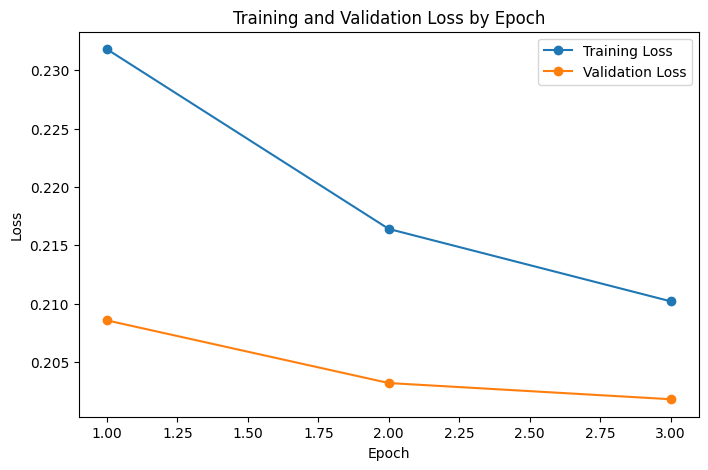

In [ ]:
import matplotlib.pyplot as plt
epochs = [1, 2, 3]
training_loss = [0.231800, 0.216400, 0.210200]
validation_loss = [0.208564, 0.203196, 0.201809]

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import os
model_path = "/content/gdrive/My Drive/e2e"
if not os.path.exists(model_path):
    os.makedirs(model_path)


In [ ]:

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


('/content/gdrive/My Drive/e2e/tokenizer_config.json',
 '/content/gdrive/My Drive/e2e/special_tokens_map.json',
 '/content/gdrive/My Drive/e2e/spiece.model',
 '/content/gdrive/My Drive/e2e/added_tokens.json')

In [ ]:
!ls /content/gdrive/MyDrive/e2e


added_tokens.json  generation_config.json  special_tokens_map.json  tokenizer_config.json
config.json	   model.safetensors	   spiece.model


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = '/content/gdrive/My Drive/e2e/'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
# !pip install rouge_score evaluate


In [ ]:
# !git lfs install
# !huggingface-cli login
# !git config --global user.email "dhakalmahima18@gmail.com"
# !git config --global user.name "mahima"
# ! cd /content/gdrive/e2e/
# ! git init
# ! git lfs track "*.bin"  # Track large files with LFS
# ! git add .gitattributes
# ! git add .
# ! git commit -m "Initial model commit"
# ! git remote add origin https://huggingface.co/mahima18/qat5
# ! git push origin main



Git LFS initialized.


In [ ]:
def generate_question(text, model=model, tokenizer=tokenizer, max_length=64):    # Encode the text input ensuring padding and truncation
    input_ids = tokenizer.encode("context: " + text, return_tensors="pt", max_length=512, padding="max_length", truncation=True).to(model.device)
    output_ids = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)

    # Decode the output to text
    question = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(question)




In [ ]:

text = "Albert Einstein was a German-born theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics. His work is also known for its influence on the philosophy of science."

text2="""
Mount Everest[3] is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas. The China–Nepal border runs across its summit point.[4] Its elevation (snow height) of 8,848.86 m (29,031 ft 8+1⁄2 in) was most recently established in 2020 by the Chinese and Nepali authorities.[5][6]

Mount Everest attracts many climbers, including highly experienced mountaineers. There are two main climbing routes, one approaching the summit from the southeast in Nepal (known as the "standard route") and the other from the north in Tibet. While not posing substantial technical climbing challenges on the standard route, Everest presents dangers such as altitude sickness, weather, and wind, as well as hazards from avalanches and the Khumbu Icefall. As of November 2022, 310 people have died on Everest. Over 200 bodies remain on the mountain and have not been removed due to the dangerous conditions.[7][8]

The first recorded efforts to reach Everest's summit were made by British mountaineers. As Nepal did not allow foreigners to enter the country at the time, the British made several attempts on the north ridge route from the Tibetan side. After the first reconnaissance expedition by the British in 1921 reached 7,000 m (22,970 ft) on the North Col, the 1922 expedition pushed the north ridge route up to 8,320 m (27,300 ft), marking the first time a human had climbed above 8,000 m (26,247 ft). The 1924 expedition resulted in one of the greatest mysteries on Everest to this day: George Mallory and Andrew Irvine made a final summit attempt on 8 June but never returned, sparking debate as to whether they were the first to reach the top. Tenzing Norgay and Edmund Hillary made the first documented ascent of Everest in 1953, using the southeast ridge route. Norgay had reached 8,595 m (28,199 ft) the previous year as a member of the 1952 Swiss expedition. The Chinese mountaineering team of Wang Fuzhou, Gonpo, and Qu Yinhua made the first reported ascent of the peak from the north ridge on 25 May 1960.[9]"""

t="mahima is fond of python. she like programming.it is her hobby.python is very famous"

generate_question(t)



What is mahima's hobby?


In [ ]:
too="""
The first recorded efforts to reach Everest's summit were made by British mountaineers. As Nepal did not allow foreigners to enter the country at the time, the British made several attempts on the north ridge route from the Tibetan side. After the first reconnaissance expedition by the British in 1921 reached 7,000 m (22,970 ft) on the North Col, the 1922 expedition pushed the north ridge route up to 8,320 m (27,300 ft), marking the first time a human had climbed above 8,000 m (26,247 ft). The 1924 expedition resulted in one of the greatest mysteries on Everest to this day: George Mallory and Andrew Irvine made a final summit attempt on 8 June but never returned, sparking debate as to whether they were the first to reach the top. Tenzing Norgay and Edmund Hillary made the first documented ascent of Everest in 1953, using the southeast ridge route. Norgay had reached 8,595 m (28,199 ft) the previous year as a member of the 1952 Swiss expedition. The Chinese mountaineering team of Wang Fuzhou, Gonpo, and Qu Yinhua made the first reported ascent of the peak from the north ridge on 25 May 1960.[9]"""

generate_question(too)


Who made the first recorded ascent of Everest in 1953?
